In [1]:
import tensorflow as tf

2025-05-22 09:27:41.206455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747906061.661865      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747906061.785180      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install scipy

In [3]:
import glob # File path pattern matching (e.g., find all .jpg files in a directory).
import imageio # Read/write image data (supports various formats, including animations/video).
import matplotlib.pyplot as plt # Plotting/visualization (e.g., loss curves, displaying images).
import numpy as np # Numerical operations on array/matrix data.
import os # Interact with the operating system (file/directory management).
import PIL # Python Imaging Library, Pillow), Basic image processing (resize, crop, convert formats).
from tensorflow.keras import layers # Neural network layer definitions (e.g., Dense, Conv2D).
import time #Measure execution time.

from IPython import display # Dynamic output in Jupyter notebooks.
from PIL import Image
from scipy import linalg
import csv

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from scipy.linalg import sqrtm
import math

In [55]:
from tqdm import tqdm

In [ ]:
print("Is GPU Available? ", tf.config.list_physical_devices('GPU'))

In [4]:
 # Create a directory if it is not there, so we can save files and results in it
from pathlib import Path
Path('/kaggle/working/resized_images').mkdir(parents=True, exist_ok=True)

In [5]:
 # Create a directory if it is not there, so we can save files and results in it
from pathlib import Path
Path('/kaggle/working/generated_images').mkdir(parents=True, exist_ok=True)

In [6]:
input_dir = '/kaggle/input/pneumonia/Pneumonia'
output_dir = '/kaggle/working/resized_images'

os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(('.jpeg', '.png')):
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path)
        resized_img = img.resize((224, 224), Image.LANCZOS)  # High-quality downsampling
        resized_img.save(os.path.join(output_dir, filename))

In [7]:
def load_single_class_dataset(dataset_path, img_size=(224, 224), batch_size=32):
    # Load images from the single class directory
    class_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        labels=None,  # No labels (we'll assign them manually)
        color_mode='grayscale',
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
    )

    # Convert to NumPy array
    images = np.concatenate([x.numpy() for x in class_dataset], axis=0)
    
    # Assign a dummy label (e.g., 0 for COVID)
    labels = np.zeros(len(images), dtype=int)

    # Normalize to [-1, 1]
    images = (images - 127.5) / 127.5

    return (images, labels), (None, None)

# Usage: Load ONLY the "COVID" class
class_name = "/kaggle/working"  # Change this to your desired class (e.g., "Normal", "Lung_Opacity")
dataset_path = os.path.join(
    '/kaggle/working',
    class_name,
    'resized_images'  # Path to the images subdirectory
)

(train_images, train_labels), (_, _) = load_single_class_dataset(dataset_path)

Found 5610 files.


I0000 00:00:1747906242.860871      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747906242.861534      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

In [28]:
# Batch and shuffle the data
# Creating a TensorFlow Dataset Pipeline
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [29]:
def make_generator_model():
    model = tf.keras.Sequential()

    # Start with a 7x7 base
    model.add(layers.Dense(7*7*512, use_bias=False, input_shape=(256,)))  # 7x7x512
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 512)))

    # Upsample to 14x14
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 28x28
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 56x56
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 112x112
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 224x224
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final layer: Output 224x224x1
    model.add(layers.Conv2DTranspose(
        1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'
    ))

    return model

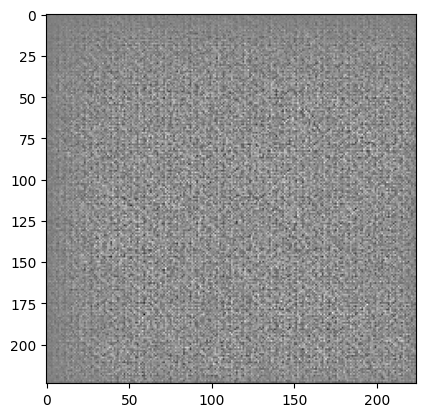

In [30]:
generator = make_generator_model()

noise = tf.random.normal([1, 256])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#A grayscale image (224x224 pixels) displayed via matplotlib.

In [31]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    # Input: 224x224x1 (matches generator output)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(224, 224, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to 112x112
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to 56x56
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to 28x28
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to 14x14
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [32]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-4.969947e-05]], shape=(1, 1), dtype=float32)


In [33]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [35]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [36]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [38]:
# --- . Setup checkpointing ---
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
epoch_counter = tf.Variable(0, dtype=tf.int64)

checkpoint = tf.train.Checkpoint(
    epoch=epoch_counter,
    generator=generator,
    discriminator=discriminator,
    gen_opt=generator_optimizer,
    disc_opt=discriminator_optimizer
)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)



In [39]:
# Restore the latest checkpoint if it exists
if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print(f"Restored from {manager.latest_checkpoint}, resuming at epoch {epoch_counter.numpy()}")
else:
    print("Starting training from scratch")

Starting training from scratch


In [40]:
# === Load InceptionV3 model ===
def get_inception_model():
    base_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    model = Model(inputs=base_model.input, outputs=base_model.output)
    return model

In [41]:
# === Load images and preprocess them ===
def load_images_from_folder(folder, target_size=(299, 299)):
    images = []
    for filename in tqdm(os.listdir(folder)):
        if filename.lower().endswith(('png', 'jpg', 'jpeg')):
            img = Image.open(os.path.join(folder, filename)).convert('RGB')  # convert to RGB
            img = img.resize(target_size)
            img = np.array(img)
            images.append(img)
    images = np.array(images).astype('float32')
    return preprocess_input(images)  # Apply InceptionV3 preprocessing

In [42]:
# === Calculate mean and covariance of features ===
def calculate_statistics(images, model):
    act = model.predict(images, batch_size=32, verbose=1)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [43]:
# === FID computation ===
def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    # Handle imaginary component due to numerical error
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [44]:
EPOCHS = 50
noise_dim = 256
num_examples_to_generate = 1

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [45]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [46]:
def train(dataset, epochs):
    for _ in range(epoch_counter.numpy(), epochs):
        start = time.time()
        current_epoch = epoch_counter.numpy() + 1

        # — 1. Training step —
        for image_batch in train_dataset:
            train_step(image_batch)

        # — 2. Save the same 32 preview images every epoch —
        display.clear_output(wait=True)
        generate_and_save_images(generator, current_epoch, seed)
        
        # — 5. Update and save checkpoint —
        epoch_counter.assign(current_epoch)
        manager.save()

    # — Final preview after the last epoch —
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [51]:
def generate_and_save_images(model, epoch, test_input, output_dir='/kaggle/working/generated_images'):
    """
    Generates and saves a grid of images.
    - model: the generator
    - epoch: current epoch for filename
    - test_input: tensor of shape (N, noise_dim)
    - cols: number of columns in the grid
    """
    # 1) Generate images
    predictions = model(test_input, training=False)
    n = predictions.shape[0]

    

    # 4) Plot each image
    for i in range(n):
        img = predictions[i, :, :, 0] * 127.5 + 127.5  # Rescale to [0, 255]
        # Create a new figure for each image
        plt.figure(figsize=(2, 2))
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    #plt.tight_layout()

    # 5) Save and close
    
    filename = f'image_epoch{epoch:04d}_img{i:03d}.png'
    filepath = os.path.join(output_dir, filename)

    plt.savefig(filepath, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()


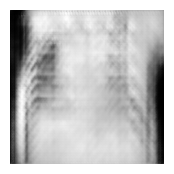

In [53]:
train(train_dataset, EPOCHS)

In [56]:
real_folder = '/kaggle/working/resized_images'
fake_folder = '/kaggle/working/generated_images'

model = get_inception_model()

real_images = load_images_from_folder(real_folder)
fake_images = load_images_from_folder(fake_folder)

mu1, sigma1 = calculate_statistics(real_images, model)
mu2, sigma2 = calculate_statistics(fake_images, model)

fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID Score: {fid_score:.4f}")


100%|██████████| 50/50 [00:00<00:00, 287.12it/s]
I0000 00:00:1747915251.335980     111 service.cc:148] XLA service 0x7f1b580103d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747915251.347725     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747915251.347764     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/176 ━━━━━━━━━━━━━━━━━━━━ 41:07 14s/step

I0000 00:00:1747915261.657353     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step  
FID Score: 437.4962
